# Seattle Police Reports - Data Cleaning Pipeline

This notebook demonstrates a complete data cleaning workflow:
1. Load raw data
2. Explore and understand the data
3. Clean and transform
4. Validate quality
5. Save cleaned data

## 1. Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# Find the most recent data file
data_dir = Path('data/raw')
data_files = sorted(data_dir.glob('kzjm-xkqj*.csv'))

if data_files:
    latest_file = data_files[-1]
    print(f"Loading: {latest_file}")
    df_raw = pd.read_csv(latest_file)
    print(f"✓ Loaded {len(df_raw):,} records")
else:
    print("❌ No data files found. Run fetch_data_gov_v2.py first!")

Loading: data\raw\kzjm-xkqj_20251005_123701.csv
✓ Loaded 5,000 records


## 2. Initial Data Exploration

In [3]:
# Basic info
print("Dataset Shape:", df_raw.shape)
print("\nColumn Names:")
print(df_raw.columns.tolist())
print("\nFirst few rows:")
df_raw.head()

Dataset Shape: (5000, 12)

Column Names:
['address', 'type', 'datetime', 'latitude', 'longitude', 'report_location', 'incident_number', ':@computed_region_ru88_fbhk', ':@computed_region_kuhn_3gp2', ':@computed_region_q256_3sug', ':@computed_region_2day_rhn5', ':@computed_region_cyqu_gs94']

First few rows:


,address,type,datetime,latitude,longitude,report_location,incident_number,:@computed_region_ru88_fbhk,:@computed_region_kuhn_3gp2,:@computed_region_q256_3sug,:@computed_region_2day_rhn5,:@computed_region_cyqu_gs94
0,100 Melrose Ave E,Aid Response,2025-10-05T10:20:00.000,47.618497,-122.327854,"{'type': 'Point', 'coordinates': [-122.327854,...",F250138095,8.0,5.0,19578,NaN,NaN
1,6110 24th Ave Nw,Aid Response,2025-10-05T10:16:00.000,47.673170,-122.387587,"{'type': 'Point', 'coordinates': [-122.387587,...",F250138094,4.0,1.0,18386,NaN,NaN
2,2300 Elliott Ave,Auto Fire Alarm,2025-10-05T10:12:00.000,47.612046,-122.348232,"{'type': 'Point', 'coordinates': [-122.348232,...",F250138091,5.0,9.0,19576,NaN,NaN
3,715 9th Ave,Medic Response,2025-10-05T10:09:00.000,47.606371,-122.325496,"{'type': 'Point', 'coordinates': [-122.325496,...",F250138089,19.0,12.0,18379,NaN,NaN
4,430 Minor Ave N,Automatic Medical Alarm,2025-10-05T10:08:00.000,47.622312,-122.332995,"{'type': 'Point', 'coordinates': [-122.332995,...",F250138088,56.0,10.0,18390,NaN,NaN


In [4]:
# Data types and missing values
print("Data Types and Missing Values:")
print("="*60)

info_df = pd.DataFrame({
    'Column': df_raw.columns,
    'Type': df_raw.dtypes.values,
    'Non-Null': df_raw.count().values,
    'Null': df_raw.isnull().sum().values,
    'Null %': (df_raw.isnull().sum() / len(df_raw) * 100).round(2).values
})

display(info_df)

Data Types and Missing Values:


,Column,Type,Non-Null,Null,Null %
0,address,object,5000,0,0.00
1,type,object,5000,0,0.00
2,datetime,object,5000,0,0.00
3,latitude,float64,4999,1,0.02
4,longitude,float64,4999,1,0.02
5,report_location,object,5000,0,0.00
6,incident_number,object,5000,0,0.00
7,:@computed_region_ru88_fbhk,float64,4996,4,0.08
8,:@computed_region_kuhn_3gp2,float64,4996,4,0.08
9,:@computed_region_q256_3sug,int64,5000,0,0.00


In [ ]:
# Unique values for categorical columns
print("Unique Values:")
print("="*60)
for col in ['type', 'address', 'incident_number']:
    if col in df_raw.columns:
        print(f"\n{col}: {df_raw[col].nunique():,} unique values")
        if col == 'type':
            print("\nTop 10 incident types:")
            print(df_raw[col].value_counts().head(10))

## 3. Data Cleaning Steps

In [5]:
# Start with a copy
df_clean = df_raw.copy()

print("Starting cleaning process...")
print(f"Initial records: {len(df_clean):,}")

Starting cleaning process...
Initial records: 5,000


### 3.1 Clean Column Names

In [6]:
# Remove special characters from column names
df_clean.columns = df_clean.columns.str.replace(':@', '', regex=False)
df_clean.columns = df_clean.columns.str.replace('computed_region_', 'region_', regex=False)

print("✓ Cleaned column names:")
print(df_clean.columns.tolist())

✓ Cleaned column names:
['address', 'type', 'datetime', 'latitude', 'longitude', 'report_location', 'incident_number', 'region_ru88_fbhk', 'region_kuhn_3gp2', 'region_q256_3sug', 'region_2day_rhn5', 'region_cyqu_gs94']


### 3.2 Parse Datetime

In [7]:
# Convert datetime string to datetime object
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'], errors='coerce')

# Extract date and time components
df_clean['date'] = df_clean['datetime'].dt.date
df_clean['time'] = df_clean['datetime'].dt.time
df_clean['hour'] = df_clean['datetime'].dt.hour
df_clean['day_of_week'] = df_clean['datetime'].dt.day_name()
df_clean['month'] = df_clean['datetime'].dt.month
df_clean['year'] = df_clean['datetime'].dt.year

print("✓ Parsed datetime columns")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")

✓ Parsed datetime columns
Date range: 2025-09-19 to 2025-10-05


### 3.3 Clean Geographic Data

In [8]:
# Convert latitude and longitude to numeric
df_clean['latitude'] = pd.to_numeric(df_clean['latitude'], errors='coerce')
df_clean['longitude'] = pd.to_numeric(df_clean['longitude'], errors='coerce')

# Create a flag for valid coordinates
df_clean['has_coordinates'] = (
    df_clean['latitude'].notna() & 
    df_clean['longitude'].notna()
)

print("✓ Cleaned geographic data")
print(f"Records with coordinates: {df_clean['has_coordinates'].sum():,} ({df_clean['has_coordinates'].sum()/len(df_clean)*100:.1f}%)")

✓ Cleaned geographic data
Records with coordinates: 4,999 (100.0%)


### 3.4 Clean Text Fields

In [9]:
# Clean address field
df_clean['address_clean'] = (
    df_clean['address']
    .str.strip()
    .str.upper()
    .str.replace(r'\s+', ' ', regex=True)
)

# Clean incident type
df_clean['incident_type'] = (
    df_clean['type']
    .str.strip()
    .str.title()
)

print("✓ Cleaned text fields")

✓ Cleaned text fields


### 3.5 Handle Missing Values

In [10]:
# Drop computed region columns (mostly missing and not needed)
region_cols = [col for col in df_clean.columns if col.startswith('region_')]
df_clean = df_clean.drop(columns=region_cols)

print(f"✓ Dropped {len(region_cols)} region columns")
print(f"Remaining columns: {len(df_clean.columns)}")

✓ Dropped 5 region columns
Remaining columns: 16


### 3.6 Create Category Groups

In [11]:
# Create high-level incident categories
def categorize_incident(incident_type):
    incident_type = str(incident_type).lower()
    
    if 'fire' in incident_type or 'alarm' in incident_type:
        return 'Fire/Alarm'
    elif 'aid' in incident_type or 'medic' in incident_type or 'medical' in incident_type:
        return 'Medical'
    elif 'assist' in incident_type or 'service' in incident_type:
        return 'Service Call'
    elif 'rescue' in incident_type:
        return 'Rescue'
    elif 'motor' in incident_type or 'vehicle' in incident_type:
        return 'Vehicle'
    else:
        return 'Other'

df_clean['incident_category'] = df_clean['incident_type'].apply(categorize_incident)

print("✓ Created incident categories:")
print(df_clean['incident_category'].value_counts())

✓ Created incident categories:
incident_category
Medical         3485
Fire/Alarm       696
Other            501
Vehicle          126
Rescue           106
Service Call      86
Name: count, dtype: int64


### 3.7 Add Data Quality Flags

In [12]:
# Create quality score
df_clean['quality_score'] = 0
df_clean.loc[df_clean['incident_number'].notna(), 'quality_score'] += 25
df_clean.loc[df_clean['datetime'].notna(), 'quality_score'] += 25
df_clean.loc[df_clean['has_coordinates'], 'quality_score'] += 25
df_clean.loc[df_clean['address'].notna(), 'quality_score'] += 25

# Flag for high quality records
df_clean['is_high_quality'] = df_clean['quality_score'] >= 75

print("✓ Added quality flags")
print(f"High quality records: {df_clean['is_high_quality'].sum():,} ({df_clean['is_high_quality'].sum()/len(df_clean)*100:.1f}%)")

✓ Added quality flags
High quality records: 5,000 (100.0%)


## 4. Data Validation and Quality Checks

In [13]:
print("Data Quality Report")
print("="*60)
print(f"\nTotal records: {len(df_clean):,}")
print(f"Records removed: {len(df_raw) - len(df_clean):,}")
print(f"\nQuality Score Distribution:")
print(df_clean['quality_score'].value_counts().sort_index())

print(f"\nMissing Values After Cleaning:")
missing = df_clean[['incident_number', 'datetime', 'latitude', 'longitude', 'address_clean']].isnull().sum()
print(missing)

Data Quality Report

Total records: 5,000
Records removed: 0

Quality Score Distribution:
quality_score
75        1
100    4999
Name: count, dtype: int64

Missing Values After Cleaning:
incident_number    0
datetime           0
latitude           1
longitude          1
address_clean      0
dtype: int64


In [14]:
# Check for duplicates
duplicates = df_clean.duplicated(subset=['incident_number']).sum()
print(f"\nDuplicate incident numbers: {duplicates}")

if duplicates > 0:
    print("Removing duplicates...")
    df_clean = df_clean.drop_duplicates(subset=['incident_number'], keep='first')
    print(f"✓ Removed {duplicates} duplicates")


Duplicate incident numbers: 0


## 5. Exploratory Data Analysis

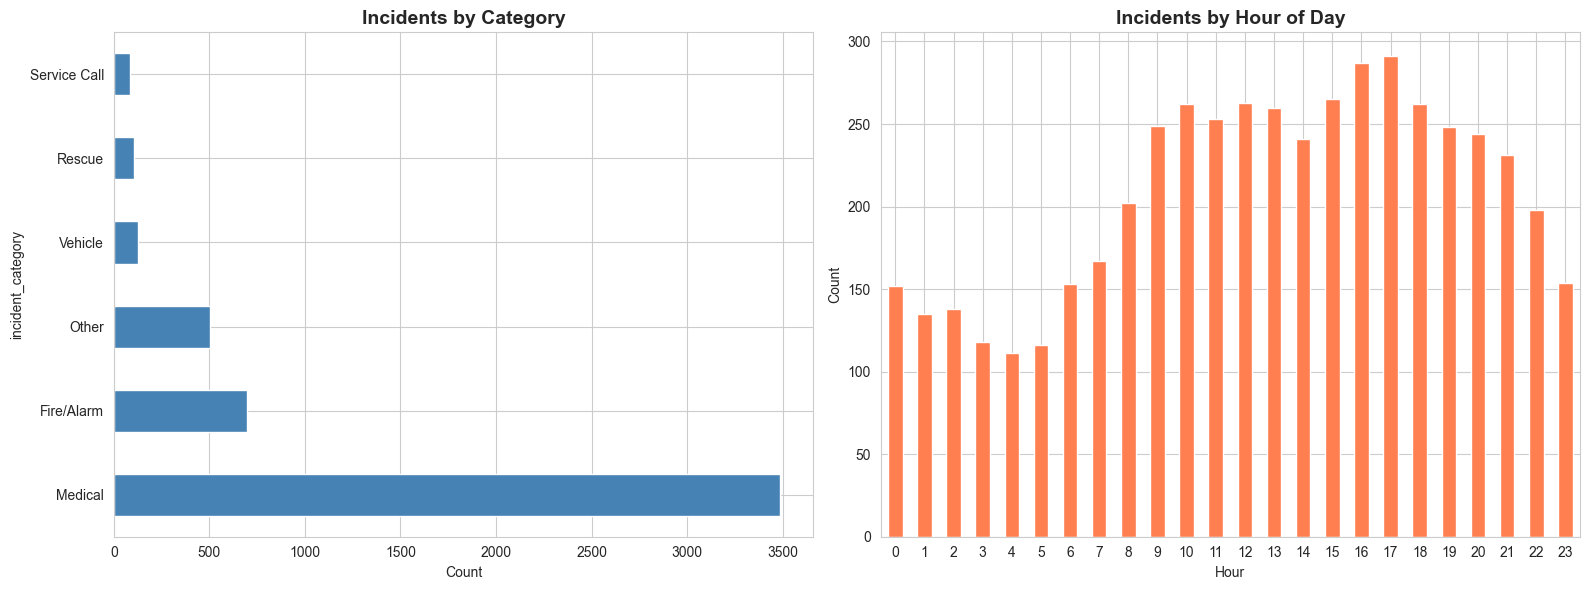

In [15]:
# Incident distribution by category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By category
df_clean['incident_category'].value_counts().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Incidents by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Count')

# By hour of day
df_clean['hour'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Incidents by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

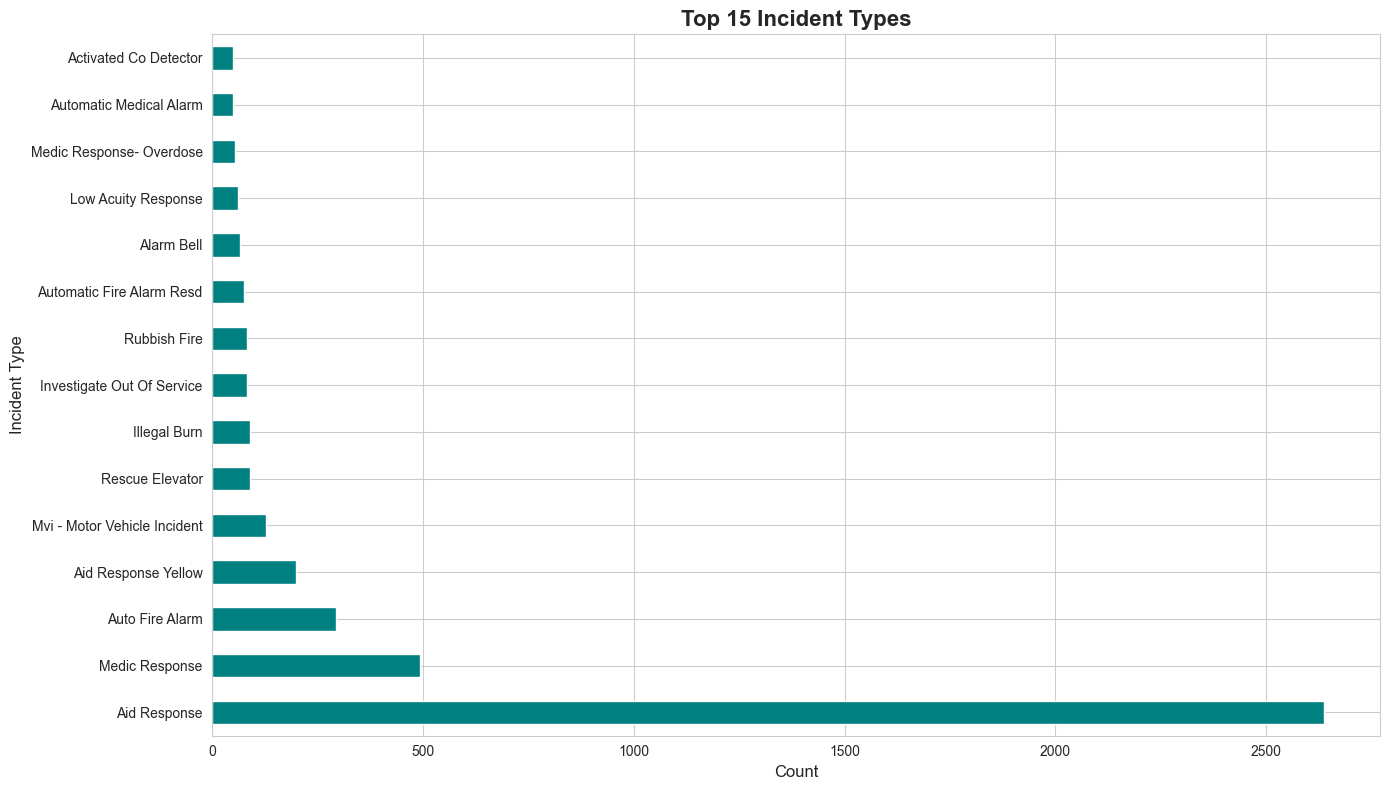

In [16]:
# Top 15 specific incident types
plt.figure(figsize=(14, 8))
df_clean['incident_type'].value_counts().head(15).plot(kind='barh', color='teal')
plt.title('Top 15 Incident Types', fontsize=16, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Incident Type', fontsize=12)
plt.tight_layout()
plt.show()

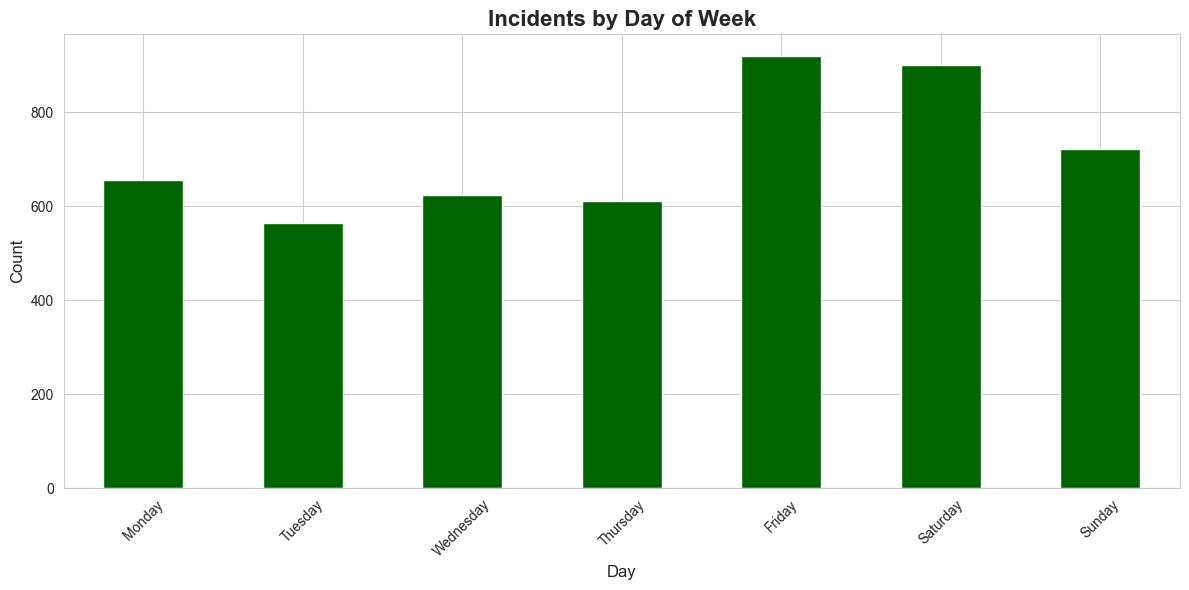

In [17]:
# Day of week analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_clean['day_of_week'].value_counts()
day_counts = day_counts.reindex(day_order)

plt.figure(figsize=(12, 6))
day_counts.plot(kind='bar', color='darkgreen')
plt.title('Incidents by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Geographic distribution (if coordinates available)
if df_clean['has_coordinates'].sum() > 100:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Sample if too many points
    sample_size = min(2000, df_clean['has_coordinates'].sum())
    df_map = df_clean[df_clean['has_coordinates']].sample(n=sample_size, random_state=42)
    
    scatter = ax.scatter(
        df_map['longitude'], 
        df_map['latitude'], 
        c=df_map['hour'],
        cmap='viridis',
        alpha=0.4,
        s=10
    )
    
    plt.colorbar(scatter, label='Hour of Day')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(f'Geographic Distribution of Incidents (n={sample_size:,})', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough coordinate data for mapping")

## 6. Final Cleaned Dataset

In [18]:
# Select final columns
final_columns = [
    'incident_number',
    'datetime',
    'date',
    'time',
    'hour',
    'day_of_week',
    'month',
    'year',
    'incident_type',
    'incident_category',
    'address_clean',
    'latitude',
    'longitude',
    'has_coordinates',
    'quality_score',
    'is_high_quality'
]

df_final = df_clean[final_columns].copy()

print("Final Dataset Summary:")
print("="*60)
print(f"Records: {len(df_final):,}")
print(f"Columns: {len(df_final.columns)}")
print(f"\nSample:")
display(df_final.head(10))

Final Dataset Summary:
Records: 5,000
Columns: 16

Sample:


,incident_number,datetime,date,time,hour,day_of_week,month,year,incident_type,incident_category,address_clean,latitude,longitude,has_coordinates,quality_score,is_high_quality
0,F250138095,2025-10-05 10:20:00,2025-10-05,10:20:00,10,Sunday,10,2025,Aid Response,Medical,100 MELROSE AVE E,47.618497,-122.327854,True,100,True
1,F250138094,2025-10-05 10:16:00,2025-10-05,10:16:00,10,Sunday,10,2025,Aid Response,Medical,6110 24TH AVE NW,47.673170,-122.387587,True,100,True
2,F250138091,2025-10-05 10:12:00,2025-10-05,10:12:00,10,Sunday,10,2025,Auto Fire Alarm,Fire/Alarm,2300 ELLIOTT AVE,47.612046,-122.348232,True,100,True
3,F250138089,2025-10-05 10:09:00,2025-10-05,10:09:00,10,Sunday,10,2025,Medic Response,Medical,715 9TH AVE,47.606371,-122.325496,True,100,True
4,F250138088,2025-10-05 10:08:00,2025-10-05,10:08:00,10,Sunday,10,2025,Automatic Medical Alarm,Fire/Alarm,430 MINOR AVE N,47.622312,-122.332995,True,100,True
5,F250138090,2025-10-05 10:08:00,2025-10-05,10:08:00,10,Sunday,10,2025,Medic Response,Medical,MADISON ST / MINOR AVE,47.609802,-122.324029,True,100,True
6,F250138087,2025-10-05 10:05:00,2025-10-05,10:05:00,10,Sunday,10,2025,Aid Response,Medical,7501 56TH AVE NE,47.683193,-122.268012,True,100,True
7,F250138086,2025-10-05 10:02:00,2025-10-05,10:02:00,10,Sunday,10,2025,Aid Response,Medical,113 23RD AVE S,47.601601,-122.302284,True,100,True
8,F250138085,2025-10-05 09:57:00,2025-10-05,09:57:00,9,Sunday,10,2025,Aid Response,Medical,100 MELROSE AVE E,47.618497,-122.327854,True,100,True
9,F250138083,2025-10-05 09:39:00,2025-10-05,09:39:00,9,Sunday,10,2025,Automatic Fire Alarm Resd,Fire/Alarm,2628 39TH AVE W,47.643124,-122.407107,True,100,True


## 7. Save Cleaned Data

In [19]:
# Create staging directory if it doesn't exist
staging_dir = Path('data/staging')
staging_dir.mkdir(parents=True, exist_ok=True)

# Save cleaned data
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = staging_dir / f'seattle_police_cleaned_{timestamp}.csv'

df_final.to_csv(output_file, index=False)

file_size = output_file.stat().st_size / (1024 * 1024)

print("="*60)
print("✓ Data Cleaning Complete!")
print("="*60)
print(f"\nSaved to: {output_file}")
print(f"Records: {len(df_final):,}")
print(f"Size: {file_size:.2f} MB")
print(f"\nNext steps:")
print("1. Review the cleaned data")
print("2. Create dbt staging model")
print("3. Build analytics models")
print("4. Create dashboards")

✓ Data Cleaning Complete!

Saved to: data\staging\seattle_police_cleaned_20251005_124242.csv
Records: 5,000
Size: 0.71 MB

Next steps:
1. Review the cleaned data
2. Create dbt staging model
3. Build analytics models
4. Create dashboards


## 8. Summary Statistics

In [20]:
# Create comprehensive summary
summary = {
    'Total Records': len(df_final),
    'Date Range': f"{df_final['date'].min()} to {df_final['date'].max()}",
    'Unique Incidents': df_final['incident_number'].nunique(),
    'Incident Types': df_final['incident_type'].nunique(),
    'With Coordinates': df_final['has_coordinates'].sum(),
    'High Quality %': f"{df_final['is_high_quality'].sum() / len(df_final) * 100:.1f}%",
    'Top Category': df_final['incident_category'].mode()[0],
    'Peak Hour': df_final['hour'].mode()[0],
    'Busiest Day': df_final['day_of_week'].mode()[0]
}

print("\n" + "="*60)
print("FINAL DATASET SUMMARY")
print("="*60)
for key, value in summary.items():
    print(f"{key:.<40} {value}")
print("="*60)


FINAL DATASET SUMMARY
Total Records........................... 5000
Date Range.............................. 2025-09-19 to 2025-10-05
Unique Incidents........................ 5000
Incident Types.......................... 74
With Coordinates........................ 4999
High Quality %.......................... 100.0%
Top Category............................ Medical
Peak Hour............................... 17
Busiest Day............................. Friday
